# 固定効果モデルの実践

In [1]:
from pathlib import Path
import statsmodels.api as ss
from statsmodels.formula.api import ols
from statsmodels.datasets import grunfeld
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
%load_ext autoreload
%autoreload 2
pd.set_option('max_rows', 1000)
pd.set_option('max_columns', 1000)

## パラメータの設定

In [3]:
result_dir_path = Path('result')

if not result_dir_path.exists():
    result_dir_path.mkdir(parents=True)

## データの取得

In [4]:
grunfeld_data = grunfeld.load_pandas().data

In [5]:
grunfeld_data.head()

,invest,value,capital,firm,year
0,317.6,3078.5,2.8,General Motors,1935.0
1,391.8,4661.7,52.6,General Motors,1936.0
2,410.6,5387.1,156.9,General Motors,1937.0
3,257.7,2792.2,209.2,General Motors,1938.0
4,330.8,4313.2,203.4,General Motors,1939.0


invest : 総投資  
value : 企業価値  
capital : 有形固定資産

In [6]:
grunfeld_data.to_csv('grunfeld_data.csv', index=False)

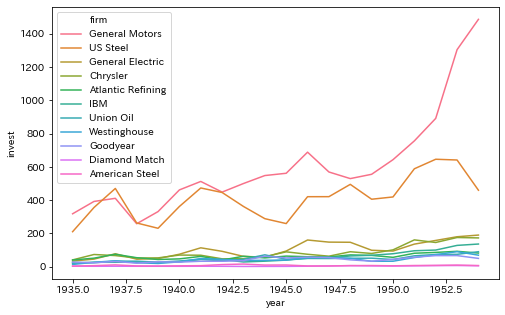

In [7]:
plt.figure(figsize=(8, 5))
sns.lineplot(
    data=grunfeld_data,
    x='year',
    y='invest',
    hue='firm'
)

## 通常の線形回帰モデル

In [8]:
model_result = ols(
    data=grunfeld_data,
    formula='invest ~ +1 + capital + value '
).fit()

model_result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 invest   R-squared:                       0.818
Model:                            OLS   Adj. R-squared:                  0.816
Method:                 Least Squares   F-statistic:                     487.3
Date:                Sun, 13 Sep 2020   Prob (F-statistic):           5.58e-81
Time:                        16:43:51   Log-Likelihood:                -1301.3
No. Observations:                 220   AIC:                             2609.
Df Residuals:                     217   BIC:                             2619.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -38.4101      8.413     -4.565      0.000     -54.992     -21.828
capital        0.2275      0.024      9.390      0.000       0.180       0.275
value          0.1145      0.006     20.753      0.000       0.104       0.125
==============================================================================
Omnibus:                       33.923   Durbin-Watson:                   0.357
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              139.212
Skew:                           0.491   Prob(JB):                     5.90e-31
Kurtosis:                       6.771   Cond. No.                     2.27e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.27e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## 固定効果モデルの実践

### 時間平均を引く

In [9]:
target_data = grunfeld_data.loc[
    :, ['firm', 'year', 'invest', 'capital', 'value']
]
target_data = target_data.set_index(['firm', 'year'])
target_data = target_data.stack()
target_data = target_data.reset_index()
target_data.columns = ['firm', 'year', 'colname', 'value']

target_data_mean = target_data.groupby(['firm', 'colname'])['value'].mean()
target_data_mean = target_data_mean.reset_index()
target_data_mean.rename(columns={'value':'value_mean'}, inplace=True)

target_data = pd.merge(target_data, target_data_mean, on=['firm', 'colname'], how='left')
target_data['value'] = target_data['value'] - target_data['value_mean']

target_data = pd.pivot_table(
    data=target_data.loc[:, ['firm', 'year', 'colname', 'value']],
    index=['firm', 'year'],
    columns='colname'
)
target_data.columns = [col[1] for col in target_data.columns]
target_data = target_data.reset_index()

### 時間平均を引いたデータで線形回帰

In [10]:
model_result = ols(
    data=target_data,
    formula='invest ~ -1 + capital + value '
).fit()

model_result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                 invest   R-squared (uncentered):                   0.767
Model:                            OLS   Adj. R-squared (uncentered):              0.765
Method:                 Least Squares   F-statistic:                              358.2
Date:                Sun, 13 Sep 2020   Prob (F-statistic):                    1.28e-69
Time:                        16:43:54   Log-Likelihood:                         -1167.4
No. Observations:                 220   AIC:                                      2339.
Df Residuals:                     218   BIC:                                      2346.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
capital        0.3100      0.016     19.236      0.000       0.278       0.342
value          0.1101      0.011     10.002      0.000       0.088       0.132
==============================================================================
Omnibus:                       35.893   Durbin-Watson:                   0.972
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              243.455
Skew:                           0.297   Prob(JB):                     1.36e-53
Kurtosis:                       8.119   Cond. No.                         1.74
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""